In [488]:
#Chargement des données, classe binaire
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV

   
def read_libsvm(fname):
    with open(fname) as f:
        x,y  =list(),list()
        for l in f:
            line = l.strip().split(" ")
            y.append(int(line[0]))
            x.append([float(s.split(":")[1]) for s in line[1:]])
    return np.array(y),np.array(x);

data= read_libsvm('/users/melkigabriel/Downloads/australian_data.txt')

data= data[0],data[1][:,3:6]


x_train, x_test,y_train, y_test = train_test_split(data[1], data[0],train_size=0.4)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Question1
Créons la class bagging.
Dans init, on rentre les paramètres et on fit. 
Puis on l'utilise avec predict


In [489]:

from sklearn.utils import resample

class bagging:
    def __init__(self,nbClassifieurs,x,y,typeClassifieur,profondeur,taille_de_sample):
        
        dataset =np.concatenate((x_train,y_train.reshape(len(x_train),1)),axis=1)
        
        if(typeClassifieur=='arbre'):
            ensembleClassifieurs=dict()
            for k in range(0,nbClassifieurs):
                dataset_loop = resample(dataset,n_samples=int(len(x_train)*taille_de_sample),replace=True) #C'est là que s'opère le bootstrap
                
                regr_loop = tree.DecisionTreeClassifier(max_depth=profondeur)
                regr_loop.fit(dataset_loop[:,0:len(x[0])],dataset_loop[:,len(x[0])])
                ensembleClassifieurs[k]=regr_loop 
            self.models = ensembleClassifieurs
    
    def predict(self,entree):
        votes=dict()
        for k in range(0,len(self.models)):
            vote=int(self.models[k].predict(entree.reshape(1, len(entree))))
            if vote in votes.keys():
                votes[vote]+=1
            else:
                votes[vote]=1
        #print(votes)
        return(max(votes, key=votes.get));


# Question 2

In [490]:
bagging_1= bagging(nbClassifieurs=6 , x=x_train , y=y_train,typeClassifieur='arbre',profondeur=1,taille_de_sample=0.3)

one_tree =tree.DecisionTreeClassifier(max_depth=1)
one_tree.fit(x_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [491]:
accuracy_bagg_train=0.0
accuracy_bagg_test =0.0
accuracy_tree_train=0.0
accuracy_tree_test =0.0

for j in range(0,len(x_test)):
    accuracy_tree_test += 1*(float(one_tree.predict(x_test[j].reshape(1,len(x_test[j])))==y_test[j]))/len(x_test)
    accuracy_bagg_test += 1*(bagging_1.predict(x_test[j])==y_test[j])/len(x_test)
    
for k in range(0,len(x_train)):
    accuracy_tree_train += 1*(float(one_tree.predict(x_train[k].reshape(1,len(x_train[k])))==y_train[k]))/len(x_train)
    accuracy_bagg_train += 1*(bagging_1.predict(x_train[k])==y_train[k])/len(x_train)

print("L'accuracy du tree en train est de "+str(round(accuracy_tree_train,4))+" ==  L'accuracy du tree en test est de " +str(round(accuracy_tree_test,4)))

print("L'accuracy du bagging en train est de "+str(round(accuracy_bagg_train,4))+" ==  L'accuracy du baggin en test est de " +str(round(accuracy_bagg_test,4)))


L'accuracy du tree en train est de 0.6449 ==  L'accuracy du tree en test est de 0.6377
L'accuracy du bagging en train est de 0.6449 ==  L'accuracy du baggin en test est de 0.6401


# Question 3

Nous sommes dans les hypothèses demandées: l'arbre est est un classifieur faible, il donne une accuracy légèrement supérieure à 50%. 
La taille du sample pour le bagging a une influence. En utilisant une taille de 40%, on arrive à induire une randomisation qui augmente l''accuracy en bagging. 
Toutefois, les résultats pour le bagging ne sont pas stables. Le bootstrap induit une volatilité assez grande dans les résultats. Y a-t-il un moyen de contourner cela?

# Exercice 2- Question 1
Annulons la dédrivée du risque empirique par rapport à alpha(t). Et on trouve le bon coeff. 

# Question 2

In [492]:
#pratique pour plus tard
def accuracy(model,poids,x_test,y_test):
    accuracy=0  
    for j in range(0,len(x_test)):
        accuracy += poids[j]*(model.predict(x_test[j].reshape(1,len(x_test[j])))==y_test[j])
    return(accuracy)


In [516]:
import math

class Adaboost:
    def __init__(self,x,y,T,profondeur):
        self.m=len(x)
        self.T = T
        self.clf = tree.DecisionTreeClassifier(max_depth=profondeur)
        self.clf = self.clf.fit(x, y)

        self.classifier =[]
        self.classifier.append(self.clf)

        self.epsilon= np.zeros(self.T)
        self.alpha= np.zeros(self.T)
        self.D=np.zeros((self.T,self.m))
        self.D[0].fill(1/self.m)

        self.epsilon[0]= 1-accuracy(self.clf,self.D[0],x,y)
        self.alpha[0]==0.5*math.log(1/self.epsilon[0]-1)
        for t in range(1,self.T):
            for k in range(0,self.m):
                self.D[t][k]=self.D[t-1][k]*math.exp(-self.alpha[t-1]*(y[k]==self.classifier[t-1].predict(x[k].reshape(1,len(x[0])))))
            self.D[t]/=sum(self.D[t])
            classifier_loop = tree.DecisionTreeClassifier(max_depth=profondeur)
            classifier_loop = classifier_loop.fit(x, y, sample_weight = self.D[t])
            self.classifier.append(classifier_loop)
            self.epsilon[t]=1- accuracy(classifier_loop,self.D[t],x,y)
            self.alpha[t]=0.5*math.log(1/self.epsilon[t]-1);
        
    def predict(self,x1):
        dd= sum(self.alpha[t]*self.classifier[t].predict(x1.reshape(1,len(x1))) for t in range(0,self.T))
        if(dd==0): return(np.sign(np.random.uniform(-1,1)))
        else: return(int(np.sign(dd )))

# Question 3 


Pour éviter ce problème de poids dans le classifier, on entraine un arbre sur un dataset modifié. Le  nouveau dataset fait apparaitre plus de fois les observations qui ont un poids fort dans D[t]. 
Il faut mettre des poids entiers, donc modifier D(t). Puisque que tous les poids D sont inférieur à 1, on diviser par le min(D) l'ensemble du dataset et arrondir pour arriver à un new_D rempli d'entiers.
On crée alors une nouveau dataset qui recopie chaque x_train[i] plusieurs fois, new_D[i] fois. Et ensuite, entrainer notre new_clf sur ce nouveau dataset.

In [517]:
from itertools import repeat

D= np.ones(len(y_train))
for k in range(len(y_train)):
    D[k]*=random.uniform(0,0.05)


new_D = D/min(D)
for k in range(len(y_train)):
    new_D[k] = int(new_D[k])

new_dataset_x = []
new_dataset_y = []
for i in range(len(x_train)):
    for k in repeat(x_train[i],int(new_D[i])):
        new_dataset_x.append(k)
    for k in repeat(y_train[i],int(new_D[i])):
        new_dataset_y.append(k)

regr_ada =tree.DecisionTreeClassifier(max_depth=2)
regr_ada.fit(new_dataset_x,new_dataset_y)  

#Et on pourrait répéter cela pour tous les classifieurs à chaque itération !

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Question 4

In [527]:
test_adaboost= Adaboost(x=x_train,y=y_train,T=5,profondeur=1)

accuracy_adaboost_test=0.0
accuracy_adaboost_train=0.0
for k in range(len(x_test)):
    accuracy_adaboost_test += 1*(test_adaboost.predict(x_test[k])==y_test[k])/len(x_test) 

for i in range(len(x_train)):
    accuracy_adaboost_train += 1*(test_adaboost.predict(x_train[i])==y_train[i])/len(x_train) 

print("L'accuracy du adaboost en train est de "+str(round(accuracy_adaboost_train,4))+" ==  L'accuracy du adaboost en test est de " +str(round(accuracy_adaboost_test,4)))


L'accuracy du adaboost en train est de 0.6848 ==  L'accuracy du adaboost en test est de 0.6329


# Question 5

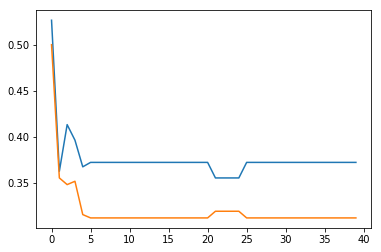

In [528]:
adaboost=dict()
D=np.ones(len(x_train))/len(x_train)
to_plot_adaboost_test=np.zeros(40)
to_plot_adaboost_train=np.zeros(40)

for i in range(1,41):
    adaboost[i]=Adaboost(x_train,y_train,i,1)
    for k in range(len(x_test)):
        to_plot_adaboost_test[i-1] += 1*(adaboost[i].predict(x_test[k])!=y_test[k]) 
    to_plot_adaboost_test[i-1]/= len(x_test)
    
    for p in range(len(x_train)):
        to_plot_adaboost_train[i-1] += 1*(adaboost[i].predict(x_train[p])!=y_train[p]) 
    to_plot_adaboost_train[i-1]/= len(x_train)
    
import matplotlib.pyplot as plt
plt.plot(to_plot_adaboost_test)
plt.plot(to_plot_adaboost_train)
plt.show()

# Question 6

In [534]:
#Reprenons test_adaboost = Adaboost(x=x_train,y=y_train,T=100,profondeur=1) et regardons le dernier D Regardons alors 'i
D_last=test_adaboost.D[4]

most_difficult = np.where(D_last>np.percentile(D_last,50))
ada = 0.0
bag= 0.0
tre= 0.0
for i in most_difficult[0]:
    ada += 1*(test_adaboost.predict(x_train[i])==y_train[i])/len(x_train)
    bag += 1*(bagging_1.predict(x_train[i])==y_train[i])/len(x_train)
    tre += 1*(int(one_tree.predict(x_train[i].reshape(1,3)))==y_train[i])/len(x_train)
print(ada,bag,tre)

0.0652173913043 0.0289855072464 0.0253623188406


Sur l'ensemble des points les plus difficiles à classer, L'adaboost marche mieux que le bagging ou que l'arbre.

# Question 7

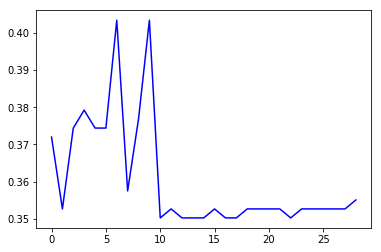

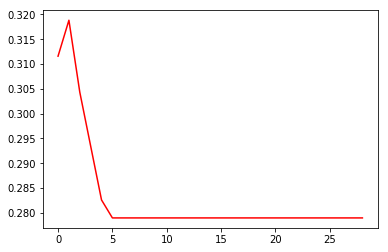

In [535]:
adaboost_profondeur=dict()
D=np.ones(len(x_train))/len(x_train)
to_plot_adaboost_test=np.zeros(29)
to_plot_adaboost_train=np.zeros(29)

for i in range(1,30):
    adaboost_profondeur[i]=Adaboost(x_train,y_train,20,i)
    for k in range(len(x_test)):
        to_plot_adaboost_test[i-1] += 1*(adaboost_profondeur[i].predict(x_test[k])!=y_test[k]) 
    to_plot_adaboost_test[i-1]/= len(x_test)
    
    for p in range(len(x_train)):
        to_plot_adaboost_train[i-1] += 1*(adaboost_profondeur[i].predict(x_train[p])!=y_train[p]) 
    to_plot_adaboost_train[i-1]/= len(x_train)

import matplotlib.pyplot as plt
plt.plot(to_plot_adaboost_test,'b')
plt.show()
plt.plot(to_plot_adaboost_train,'r')
plt.show()

In [536]:
#la généralisation se passe mal lorsque l'on augmente la taille des arbres. Il y a clairement du surapprentissage!